In [1]:
# xbotinterface imports (for modelinterface)
from xbot_interface import xbot_interface as xbot
from xbot_interface import config_options as co

# cartesio imports (for Affine3 and IK solver)
from cartesian_interface.pyci_all import *
import cartesian_interface.roscpp_utils as roscpp

# multi_contact_planning imports
from multi_contact_planning import planning
from multi_contact_planning import validity_check
from multi_contact_planning import visual_tools
from multi_contact_planning import constraints

# linear algebra, yaml, ros, ...
import numpy as np
import scipy.linalg as la
import yaml
import moveit_msgs.msg 
import rospy
import StringIO


# we need to initialize roscpp (underlying code is in C++!)
cpp_argv = []
if not roscpp.init('teleop_example', cpp_argv):
    print 'Unable to initialize roscpp node!'

In [2]:
# get robot description from param server
urdf = rospy.get_param('robot_description')
srdf = rospy.get_param('robot_description_semantic')

# make xbot model
opt = co.ConfigOptions()
opt.set_urdf(urdf)
opt.set_srdf(srdf)
opt.generate_jidmap()
opt.set_bool_parameter('is_model_floating_base', True)
opt.set_string_parameter('model_type', 'RBDL')

model = xbot.ModelInterface(opt)

# define joint range
qmin, qmax = model.getJointLimits()
yaml_options = '' # leave default options

# make planning scene
ps = validity_check.PlanningSceneWrapper(model)
ps.startMonitor() # listen to topics / publish planning scene for visualization
ps.startGetPlanningSceneServer()  # advertise get_planning_scene srv for rviz

In [3]:
# add a box and two spheres to the planning scene
#ps.addBox('box', [0.1, 0.8, 0.1], Affine3(pos=[0.3, 0.2, 0.5]))
#ps.addSphere('sphere_1', 0.1, Affine3(pos=[0.55, -0.3, 0.2]))
#ps.addSphere('sphere_2', 0.2, Affine3(pos=[0.2, -0.4, 0.5]))

In [4]:
# our validity checker checks for collisions
def model_validity_checker():
    ps.update()
    return not ps.checkCollisions()

def validity_checker(q):
    model.setJointPosition(q)
    model.update()
    return model_validity_checker()

In [5]:
# write an ik problem to describe the manifold z = const
wheels = ['wheel_{}'.format(i) for i in range(1, 5)]

ik = {}
ik['solver_options'] = {}
ik['stack'] = [wheels]
ik['constraints'] = ['JointLimits'] #, 'VelocityLimits']

ik['JointLimits'] = {
    'type': 'JointLimits'
}

ik['VelocityLimits'] = {
    'type': 'VelocityLimits',
    'limits': 0.5
}

for w in wheels:
    ik[w] = {
        'type': 'Cartesian',
        'distal_link': w,
        'indices': [0, 1, 2, 3, 4]
    }

ik_str = yaml.dump(ik)

# constraint from cartesian interface solver
ci = pyci.CartesianInterface.MakeInstance('OpenSot', ik_str, model, 1.0)
constr = constraints.CartesianConstraint(ci)

In [6]:
# define start state (joint space)
start = model.getRobotState('home')

# set constraint to pass through the start state
model.setJointPosition(start)
model.update()
constr.reset()

# check constraint consistency
print 'Constraint value at q = start is {}'.format(constr.function(start))

# Check start state is valid
print 'Start state valid: {}'.format(validity_checker(start))
print ps.getCollidingLinks()

# Publish it to a marker array
start_viz = visual_tools.RobotViz(model, '/teleop_example/start', color=[0, 0, 1, 0.5])
start_viz.publishMarkers(ps.getCollidingLinks())

Constraint value at q = start is [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]
Start state valid: True
[]


In [7]:
# use a goal sampler to compute a joint space goal from a cartesian space goal
hands = ['arm1_8', 'arm2_8']
ik['stack'][0] += hands
#ik['stack'].append(['Postural'])
ik['solver_options']['regularization'] = 1e-2

for h in hands:
    ik[h] = {
            'type': 'Cartesian',
            'distal_link': h,
            'indices': [0, 1, 2]
        }

ik['Postural'] = {
        'type': 'Postural',
        'lambda': 0.01
    }

ik_str = yaml.dump(ik)
rospy.set_param('cartesian/problem_description', ik_str)
ci_goal = pyci.CartesianInterface.MakeInstance('OpenSot', ik_str, model, 1.0)
pos_ik = planning.PositionCartesianSolver(ci_goal)

In [8]:
pos_ik.setMaxIterations(50)
pos_ik.setDesiredPose('arm1_8', Affine3(pos=[0.6, 0.15, 0.7]))
pos_ik.setDesiredPose('arm2_8', Affine3(pos=[0.6, -0.15, 0.7]))
goal_viz = visual_tools.RobotViz(model, '/teleop_example/goal', color=[0, 1, 0, 0.5])   

In [9]:
goal = start.copy()
goal_found = False
q0 = None
np.random.seed(121)

while not goal_found:
    
    model.setJointPosition(goal)
    model.update()

    if not pos_ik.solve(): 
        
        print 'Unable to solve'
        
    else:
       
        if q0 is None:
            
            q0 = goal.copy()
       
        ps.update()
        goal_viz.publishMarkers(ps.getCollidingLinks())
        goal_found = model_validity_checker()

    if not goal_found:
        
        J = pos_ik.getJacobian()
        U, S, V = la.svd(J)
        null_dim = J.shape[1] - J.shape[0]
        N = V[:, -null_dim-1:-1] # last nulldim cols
        rho = 1

        delta_q = N.dot(np.random.uniform(-rho, rho, size=null_dim))
        goal = q0 + delta_q
        goal = np.minimum(goal, qmax)
        goal = np.maximum(goal, qmin)
        
goal = model.getJointPosition()
goal = np.minimum(goal, qmax)
goal = np.maximum(goal, qmin)

if not validity_checker(goal):
    raise RuntimeError('Invalid state')
    
if np.any(goal > qmax) or np.any(goal < qmin):
    print((goal > qmax) * (goal - qmax))
    print((goal < qmin) * (qmin - goal))
    raise RuntimeError('Invalid bounds')
    
planner = None

In [ ]:
# Execute planner
import math 

planner_type = 'RRTstar'
timeout = 1.0
threshold = 0.0

planner_config = {

    'state_space': {
        'type': "Atlas"
    },
    
    'AAtlas': {
        'exploration': 0.99,
        'alpha': math.pi/3.0
    }
}

# create planner
qmin[0:6] = np.full(6, -6.0)
qmax[0:6] = -qmin[0:6]
if planner is None:
    planner = planning.OmplPlanner(constr, 
                               qmin, qmax, 
                               yaml.dump(planner_config))

planner.setStartAndGoalStates(start, goal, threshold)
planner.setStateValidityPredicate(validity_checker)
success = planner.solve(timeout, planner_type)

print 'Planner output : {}'.format(success)

if success:
    solution = np.array(planner.getSolutionPath()).transpose()
    error = solution[:, -1] - np.array(goal)
    print 'Error is {} rad'.format(la.norm(error))

In [40]:
# Plot solution
%matplotlib inline
import matplotlib.pyplot as plt

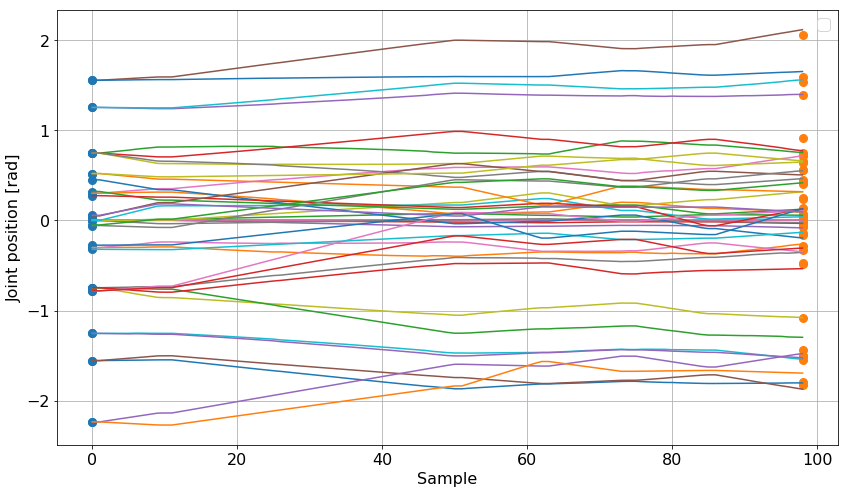

In [41]:
plt.rcParams.update({'figure.figsize': [14, 8],
                     'font.size': 16})

plt.plot(np.full_like(start, 0), start, '.', markersize=16)
plt.plot(np.full_like(goal, solution.shape[1]-1), goal, '.', markersize=16)
plt.plot(solution.transpose(), '-')
plt.grid()
plt.xlabel('Sample')
plt.ylabel('Joint position [rad]')
plt.legend()

In [42]:
# Play solution a number of times..
viz = visual_tools.RobotViz(model, 
                            '/teleop_example/solution', 
                            color=[0.5, 0, 0.5, 0.5])

ntimes = 10
duration = 3.0
dt = duration/solution.shape[1]

for _ in range(ntimes):
    
    for i in range(solution.shape[1]):
        
        q = solution[:, i]
        model.setJointPosition(q)
        model.update()
        viz.publishMarkers()
        rospy.sleep(dt)